## Installing Dependencies

In [1]:
#pip install pydot

In [2]:
#pip install graphviz

## Importing Libraries

In [1]:
import os
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt 
import numpy as np
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import pandas as pd

import cv2
import os
from keras.models import load_model
from pygame import mixer
import time

pygame 2.1.2 (SDL 2.0.18, Python 3.8.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Data Exploration

In [2]:
#defining the data location
DATASET_LOCATION = "data"
Train_DATASET_LOCATION = "data/train"
Test_DATASET_LOCATION = "data/test"

Train_filenames = os.listdir(Train_DATASET_LOCATION)
Test_filenames = os.listdir(Test_DATASET_LOCATION)  

#to check the classes available
classes = []
for filename in Train_filenames:
    image_class = filename.split(".")[0]
    if image_class!='':
        classes.append(image_class)  
classes

['Closed', 'no_yawn', 'yawn', 'Open']

In [3]:
#creating metadata for training data with image name, corresponding classes and the image location
Img_name = []
classes = []
for filename in Train_filenames:
    image_class = filename.split(".")[0]
    if image_class!='':
        for flnam in os.listdir(Train_DATASET_LOCATION+'/'+image_class):
            classes.append(image_class)  
            Img_name.append(flnam)  
            
df_Train = pd.DataFrame({"Image": Img_name, "Class": classes})
df_Train['Loc'] = 'train'
print(df_Train.shape)
df_Train.head()

(2467, 3)


,Image,Class,Loc
0,_80.jpg,Closed,train
1,_94.jpg,Closed,train
2,_569.jpg,Closed,train
3,_227.jpg,Closed,train
4,_233.jpg,Closed,train


In [4]:
#creating metadata for test data with image name, corresponding classes and the image location
Img_name = []
classes = []
for filename in Test_filenames:
    image_class = filename.split(".")[0]
    if image_class!='':
        for flnam in os.listdir(Test_DATASET_LOCATION+'/'+image_class):
            classes.append(image_class)  
            Img_name.append(flnam)  
            
df_Test = pd.DataFrame({"Image": Img_name, "Class": classes})
df_Test['Loc'] = 'test'
print(df_Test.shape)
df_Test.head()

(433, 3)


,Image,Class,Loc
0,_541.jpg,Closed,test
1,_347.jpg,Closed,test
2,_434.jpg,Closed,test
3,_597.jpg,Closed,test
4,_226.jpg,Closed,test


In [5]:
#combining the test and train metadata
df = pd.DataFrame()
data = [df_Train, df_Test]
df = pd.concat(data)
print(df.shape)
df.head()

(2900, 3)


,Image,Class,Loc
0,_80.jpg,Closed,train
1,_94.jpg,Closed,train
2,_569.jpg,Closed,train
3,_227.jpg,Closed,train
4,_233.jpg,Closed,train


## Data Exploration

In [6]:
#checking classes and number of images under each class
df.Class.value_counts()

Closed     726
Open       726
no_yawn    725
yawn       723
Name: Class, dtype: int64

In [7]:
#creating image location for each image
df['ImageLoc'] = df.Loc + '/' + df.Class + '/' +df.Image
print(df.shape)
df.head()

(2900, 4)


,Image,Class,Loc,ImageLoc
0,_80.jpg,Closed,train,train/Closed/_80.jpg
1,_94.jpg,Closed,train,train/Closed/_94.jpg
2,_569.jpg,Closed,train,train/Closed/_569.jpg
3,_227.jpg,Closed,train,train/Closed/_227.jpg
4,_233.jpg,Closed,train,train/Closed/_233.jpg


(314, 300)


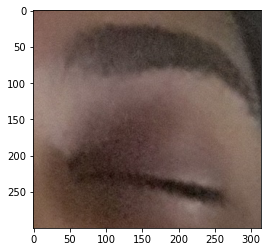

In [9]:
#to check the size of random image in eyes folder
sample1 = random.choice(os.listdir(Train_DATASET_LOCATION+'/Closed'))
image1 = load_img(Train_DATASET_LOCATION + "/Closed/" + sample1)
print(image1.size)
plt.imshow(image1)

(419, 300)


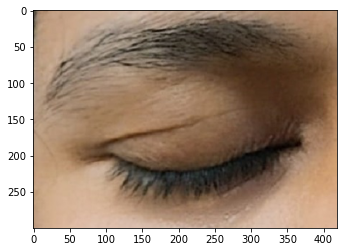

In [10]:
#to check the size of random image in eyes folder
sample2 = random.choice(os.listdir(Train_DATASET_LOCATION+'/Closed'))
image2 = load_img(Train_DATASET_LOCATION + "/Closed/" + sample2)
print(image2.size)
plt.imshow(image2)

(640, 480)


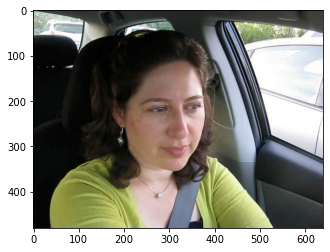

In [12]:
#to check the size of random image in yawn -no yawn folder
sample3 = random.choice(os.listdir(Train_DATASET_LOCATION+'/no_yawn'))
image3 = load_img(Train_DATASET_LOCATION + "/no_yawn/" + sample3)
print(image3.size)
plt.imshow(image3)

# Open Close eye detection

In [13]:
#loading only images with lable open and close
df_eyeOpenClose = df[df.Class.isin(['Closed','Open'])]
print(df_eyeOpenClose.shape)
df_eyeOpenClose.head()

(1452, 4)


,Image,Class,Loc,ImageLoc
0,_80.jpg,Closed,train,train/Closed/_80.jpg
1,_94.jpg,Closed,train,train/Closed/_94.jpg
2,_569.jpg,Closed,train,train/Closed/_569.jpg
3,_227.jpg,Closed,train,train/Closed/_227.jpg
4,_233.jpg,Closed,train,train/Closed/_233.jpg


In [14]:
df_eyeOpenClose.Class.value_counts()

Closed    726
Open      726
Name: Class, dtype: int64

## Data processing

In [15]:
#setting the size of the image
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)

In [17]:
#defining image processing steps
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1.0 / 255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

In [18]:
#loading data
BATCH_SIZE = 20
train_set = train_datagen.flow_from_dataframe(
    df_eyeOpenClose,
    DATASET_LOCATION,
    x_col="ImageLoc",
    y_col="Class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    subset='training'
)

test_set = train_datagen.flow_from_dataframe(
    df_eyeOpenClose,
    DATASET_LOCATION,
    x_col="ImageLoc",
    y_col="Class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    subset='validation'
)


Found 1162 validated image filenames belonging to 2 classes.
Found 290 validated image filenames belonging to 2 classes.


In [19]:
print(train_set.class_indices)
print(train_set.class_indices)

{'Closed': 0, 'Open': 1}
{'Closed': 0, 'Open': 1}


### Model 1

In [77]:
## lets define our CNN
MyCnn_base = tf.keras.models.Sequential([
  layers.Conv2D(32,(3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Conv2D(64, (3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),

  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

MyCnn_base.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

MyCnn_base.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                262208    
_________________________________________________________________
dense_26 (Dense)             (None, 2)               

In [78]:
retVal_base = MyCnn.fit(train_set, validation_data= test_set, epochs = 50)

Epoch 1/50
59/59 [==============================] - 4s 75ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.0548 - val_accuracy: 0.9793
Epoch 2/50
59/59 [==============================] - 4s 74ms/step - loss: 0.0099 - accuracy: 0.9974 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 3/50
59/59 [==============================] - 4s 75ms/step - loss: 0.0235 - accuracy: 0.9905 - val_loss: 0.0990 - val_accuracy: 0.9621
Epoch 4/50
59/59 [==============================] - 5s 78ms/step - loss: 0.0139 - accuracy: 0.9966 - val_loss: 0.0910 - val_accuracy: 0.9690
Epoch 5/50
59/59 [==============================] - 5s 80ms/step - loss: 0.0195 - accuracy: 0.9948 - val_loss: 0.0321 - val_accuracy: 0.9931
Epoch 6/50
59/59 [==============================] - 5s 78ms/step - loss: 0.0076 - accuracy: 0.9974 - val_loss: 0.0389 - val_accuracy: 0.9828
Epoch 7/50
59/59 [==============================] - 4s 75ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0108 - val_accuracy: 0.9966
Epoch 8/50
59

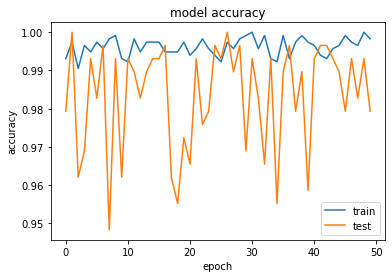

In [79]:
# summarize history for accuracy
plt.plot(retVal_base.history['accuracy'])
plt.plot(retVal_base.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

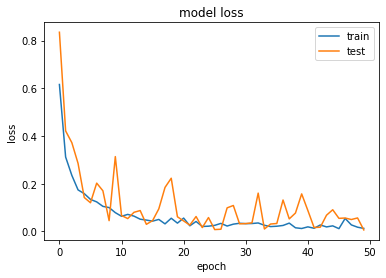

In [80]:
# summarize history for accuracy
plt.plot(retVal.history['loss'])
plt.plot(retVal.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

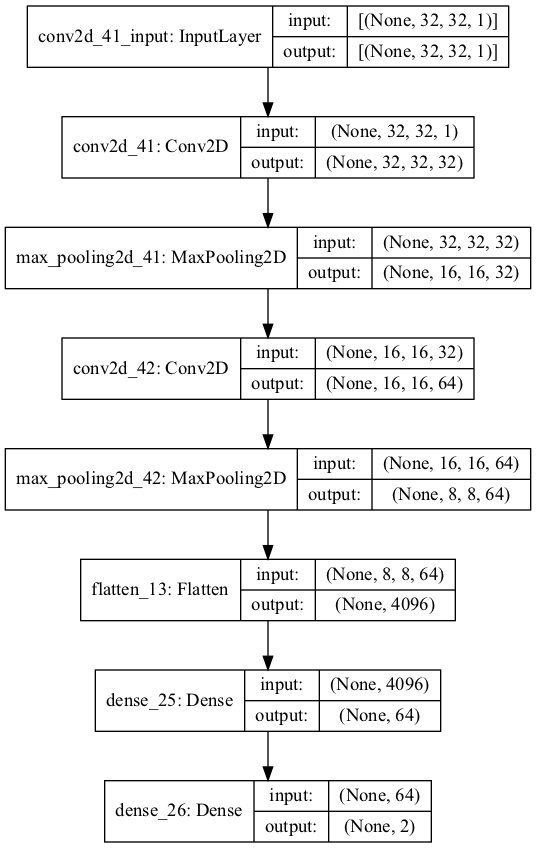

In [81]:
plot_model(MyCnn_base, to_file='MyCnn_base_plot.png', show_shapes=True, show_layer_names=True)

Tuning the CNN base model

In [69]:
## lets define our CNN
MyCnn = tf.keras.models.Sequential([
  layers.Conv2D(32,(3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Conv2D(64, (3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Conv2D(128, (3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),

  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

MyCnn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

MyCnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)             

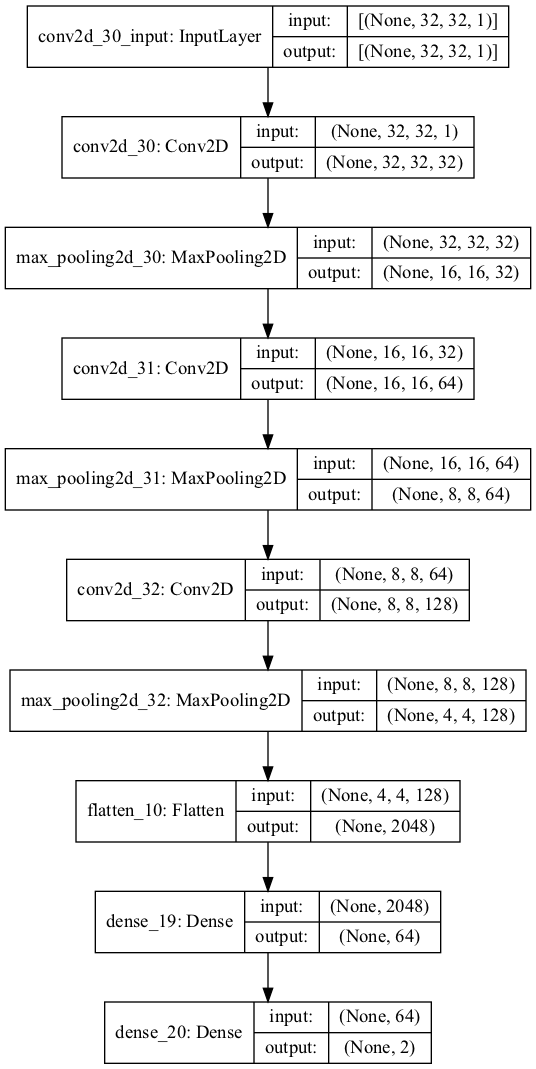

In [70]:
plot_model(MyCnn, to_file='MyCnn_plot.png', show_shapes=True, show_layer_names=True)

In [71]:
retVal = MyCnn.fit(train_set, validation_data= test_set, epochs = 50)

Epoch 1/50
59/59 [==============================] - 5s 87ms/step - loss: 0.6160 - accuracy: 0.6575 - val_loss: 0.8353 - val_accuracy: 0.4379
Epoch 2/50
59/59 [==============================] - 5s 78ms/step - loss: 0.3117 - accuracy: 0.8726 - val_loss: 0.4212 - val_accuracy: 0.8034
Epoch 3/50
59/59 [==============================] - 5s 79ms/step - loss: 0.2347 - accuracy: 0.9079 - val_loss: 0.3720 - val_accuracy: 0.8724
Epoch 4/50
59/59 [==============================] - 4s 76ms/step - loss: 0.1738 - accuracy: 0.9346 - val_loss: 0.2851 - val_accuracy: 0.9034
Epoch 5/50
59/59 [==============================] - 5s 79ms/step - loss: 0.1582 - accuracy: 0.9389 - val_loss: 0.1419 - val_accuracy: 0.9483
Epoch 6/50
59/59 [==============================] - 5s 78ms/step - loss: 0.1340 - accuracy: 0.9484 - val_loss: 0.1199 - val_accuracy: 0.9828
Epoch 7/50
59/59 [==============================] - 5s 79ms/step - loss: 0.1235 - accuracy: 0.9535 - val_loss: 0.2023 - val_accuracy: 0.9276
Epoch 8/50
59

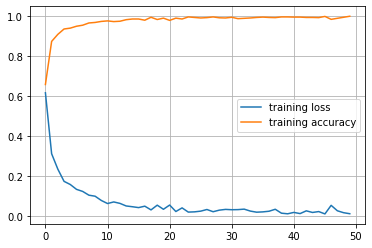

In [72]:
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

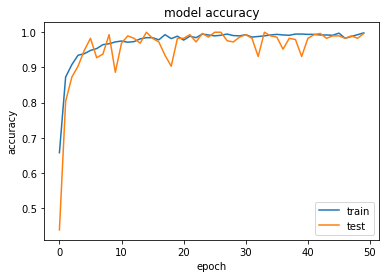

In [73]:
# summarize history for accuracy
plt.plot(retVal.history['accuracy'])
plt.plot(retVal.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

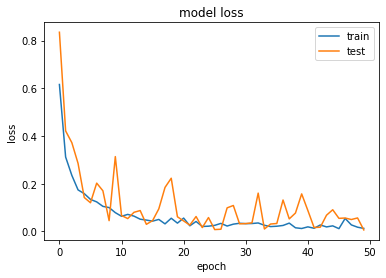

In [74]:
# summarize history for accuracy
plt.plot(retVal.history['loss'])
plt.plot(retVal.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [235]:
#saving the model
# MyCnn.save("models/open_close_eye.h5")

# Yawn no yawn

In [22]:
df_yawnNoyawn = df[df.Class.isin(['yawn','no_yawn'])]
print(df_yawnNoyawn.shape)
df_yawnNoyawn.head()

(1448, 4)


,Image,Class,Loc,ImageLoc
617,77.jpg,no_yawn,train,train/no_yawn/77.jpg
618,837.jpg,no_yawn,train,train/no_yawn/837.jpg
619,638.jpg,no_yawn,train,train/no_yawn/638.jpg
620,176.jpg,no_yawn,train,train/no_yawn/176.jpg
621,2464.jpg,no_yawn,train,train/no_yawn/2464.jpg


In [34]:
#setting the size of the image
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 1)

In [35]:
BATCH_SIZE = 20
train_set = train_datagen.flow_from_dataframe(
    df_yawnNoyawn,
    DATASET_LOCATION,
    x_col="ImageLoc",
    y_col="Class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    subset='training'
)

test_set = train_datagen.flow_from_dataframe(
    df_yawnNoyawn,
    DATASET_LOCATION,
    x_col="ImageLoc",
    y_col="Class",
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    color_mode="grayscale",
    subset='validation'
)


Found 1159 validated image filenames belonging to 2 classes.
Found 289 validated image filenames belonging to 2 classes.


In [36]:
print(train_set.class_indices)
print(test_set.class_indices)

{'no_yawn': 0, 'yawn': 1}
{'no_yawn': 0, 'yawn': 1}


### Model 1

In [37]:
## lets define our CNN
yawn_noyawn_base = tf.keras.models.Sequential([
  layers.Conv2D(32,(3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Conv2D(64, (3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),

  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

yawn_noyawn_base.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

yawn_noyawn_base.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                262208    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [38]:
yretVal_base =  yawn_noyawn_base.fit(train_set, validation_data= test_set, epochs = 50)

Epoch 1/50
58/58 [==============================] - 7s 117ms/step - loss: 0.6395 - accuracy: 0.6031 - val_loss: 0.7793 - val_accuracy: 0.3668
Epoch 2/50
58/58 [==============================] - 7s 113ms/step - loss: 0.6057 - accuracy: 0.6264 - val_loss: 0.7845 - val_accuracy: 0.2526
Epoch 3/50
58/58 [==============================] - 7s 117ms/step - loss: 0.5908 - accuracy: 0.6342 - val_loss: 0.8036 - val_accuracy: 0.3599
Epoch 4/50
58/58 [==============================] - 7s 115ms/step - loss: 0.5856 - accuracy: 0.6255 - val_loss: 1.0347 - val_accuracy: 0.1107
Epoch 5/50
58/58 [==============================] - 7s 121ms/step - loss: 0.5687 - accuracy: 0.6497 - val_loss: 0.9880 - val_accuracy: 0.1522
Epoch 6/50
58/58 [==============================] - 7s 120ms/step - loss: 0.5717 - accuracy: 0.6497 - val_loss: 0.7583 - val_accuracy: 0.3287
Epoch 7/50
58/58 [==============================] - 7s 122ms/step - loss: 0.5594 - accuracy: 0.6644 - val_loss: 0.7209 - val_accuracy: 0.5467
Epoch 

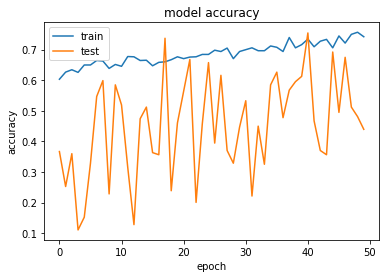

In [39]:
# summarize history for accuracy
plt.plot(yretVal_base.history['accuracy'])
plt.plot(yretVal_base.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

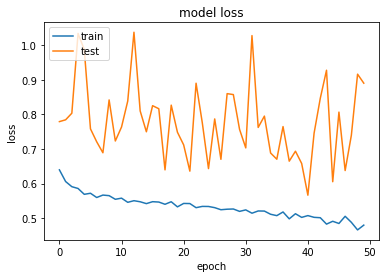

In [40]:
# summarize history for accuracy
plt.plot(yretVal_base.history['loss'])
plt.plot(yretVal_base.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
## lets define our CNN
yawn_noyawn = tf.keras.models.Sequential([
  layers.Conv2D(32,(3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Conv2D(64, (3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),
  layers.Conv2D(128, (3,3), padding = 'same', input_shape = (32,32,1), activation='relu'),
  layers.MaxPooling2D(pool_size = (2,2)),

  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(2, activation= 'softmax')
])

yawn_noyawn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

yawn_noyawn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

In [42]:
yretVal =  yawn_noyawn.fit(train_set, validation_data= test_set, epochs = 50)

Epoch 1/50
58/58 [==============================] - 9s 152ms/step - loss: 0.6499 - accuracy: 0.6368 - val_loss: 0.7657 - val_accuracy: 0.2976
Epoch 2/50
58/58 [==============================] - 8s 134ms/step - loss: 0.5959 - accuracy: 0.6368 - val_loss: 0.7748 - val_accuracy: 0.4671
Epoch 3/50
58/58 [==============================] - 8s 140ms/step - loss: 0.5665 - accuracy: 0.6471 - val_loss: 0.6757 - val_accuracy: 0.6609
Epoch 4/50
58/58 [==============================] - 9s 149ms/step - loss: 0.5745 - accuracy: 0.6186 - val_loss: 0.7539 - val_accuracy: 0.4014
Epoch 5/50
58/58 [==============================] - 8s 131ms/step - loss: 0.5663 - accuracy: 0.6316 - val_loss: 0.9012 - val_accuracy: 0.1107
Epoch 6/50
58/58 [==============================] - 8s 129ms/step - loss: 0.5625 - accuracy: 0.6480 - val_loss: 0.7504 - val_accuracy: 0.5571
Epoch 7/50
58/58 [==============================] - 8s 130ms/step - loss: 0.5826 - accuracy: 0.6221 - val_loss: 0.8111 - val_accuracy: 0.1972
Epoch 

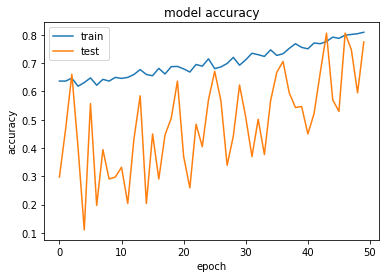

In [43]:
# summarize history for accuracy
plt.plot(yretVal.history['accuracy'])
plt.plot(yretVal.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

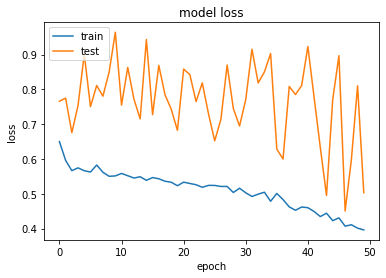

In [45]:
# summarize history for accuracy
plt.plot(yretVal.history['loss'])
plt.plot(yretVal.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

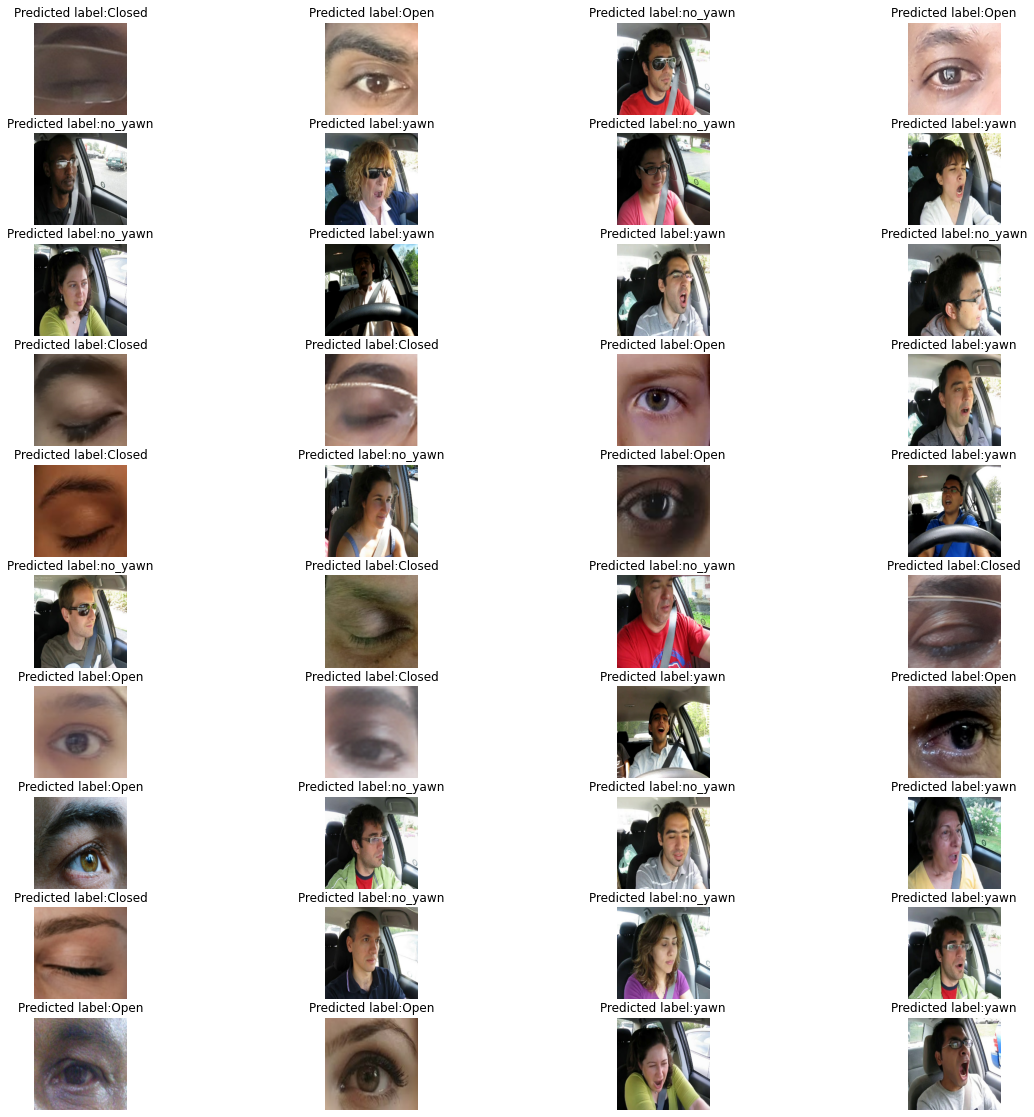

In [26]:
plt.figure(figsize=(20, 20))
for images, labels in testing_ds.take(2):
    predictions = MyCnn.predict(images)
    predlabel = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
    
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:'+ predlabel[i])
        plt.axis('off')
        plt.grid(True)